In [71]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos, exp

from scipy.integrate import solve_ivp

from typing import Callable

import sim_utils

# Fix Python 3's weird rounding function
# https://stackoverflow.com/a/44888699/538379
round2=lambda x,y=None: round(x+1e-15,y)

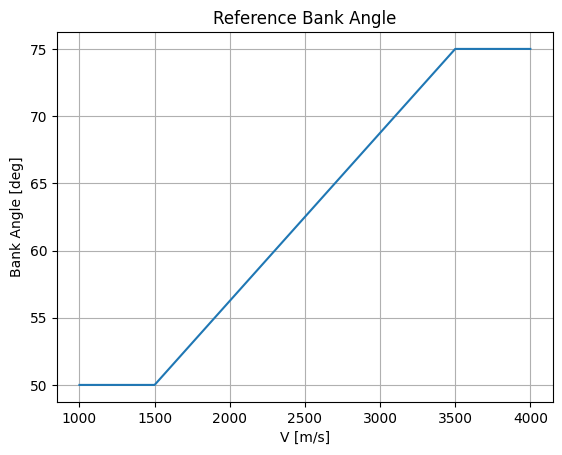

In [72]:
def reference_bank_angle(t, X, parameters):
    """Generates the reference bank angle profile"""
    v = X[2]    
    if v >= 3500:
        return np.deg2rad(75);
    elif v <= 1500:
        return np.deg2rad(50);
    else:
        return np.deg2rad(50 + (75-50)*(v-1500)/(3500-1500))

V = np.linspace(1000, 4000, 301)

bank_angle_deg = np.degrees([reference_bank_angle(0, [0, 0, v, 0], {}) for v in V], dtype=np.float64)

plt.plot(V, bank_angle_deg)
plt.xlabel('V [m/s]')
plt.ylabel('Bank Angle [deg]')
plt.grid(True)
plt.title('Reference Bank Angle')
plt.show()

In [73]:
def traj_eom(t: float, 
             state: np.array, 
             parameters: dict, 
             bank_angle_fn: Callable[[float, np.array, dict], float]
            ):
    h, s, v, gam = state
    u = bank_angle_fn(t, state, parameters)
    
    rho0 = parameters['rho0']
    H = parameters['H']
    beta = parameters['beta']   # m/(Cd * Aref)
    LD = parameters['LD']
    R_m = parameters['R_m']
    g = parameters['g']
    
    v2 = v*v
    rho = rho0 * exp(-h/H) 
    D_m = rho * v2 / (2 * beta)  # Drag Acceleration (D/m)
    r = R_m + h
    return np.array([v * sin(gam),       # dh/dt
                     v * cos(gam),       # ds/dt
                     -D_m - g*sin(gam),  # dV/dt
                     (v2 * cos(gam)/r + D_m*LD*cos(u) - g*cos(gam))/v] # dgam/dt
                   )

In [86]:
# Initial conditions
h0 = 75e3; # Entry altitude
V0 = 5500;  # Entry velocity
gamma0_deg = -14.5; # Entry flight path angle
s0 = 0

# Model parameters
parameters = {'H': 11.1e3,
              'rho0': 0.020, # kg/m^3
              'beta': 120,
              'LD': 0.24,
              'R_m': 3380e3,
              'g': 3.73}

# Terminal altitude
h_f = 0e3

gamma0 = np.deg2rad(gamma0_deg)
X0 = np.array([h0, s0, V0, gamma0])
t0 = 0
tf = 500.
tspan = np.linspace(t0, tf, 101)

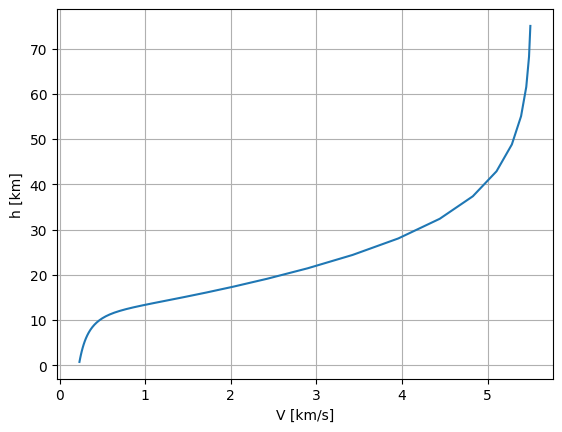

In [87]:
ref_traj = sim_utils.simulate_entry_trajectory(traj_eom, t0, tf, X0, 0, h_f, parameters, reference_bank_angle, tspan)

plt.plot(ref_traj.X[:,2]/1e3, ref_traj.X[:,0]/1e3)
plt.xlabel('V [km/s]')
plt.ylabel('h [km]')
plt.grid(True)
plt.show()

# Computing Co-States and Gains

Once the reference trajectory has been propagated, additional information is required for formulating the guidance law. These are the costates $\lambda_h$, $\lambda_s$, $\lambda_v$, $\lambda_\gamma$ and $\lambda_u$. Of these,  $\lambda_s$ was found to have a constant value of $1$ throughout the trajectory.
The remaining costates have these terminal boundary conditions associated with them:

$$
\begin{align}
\lambda_h(t_f) &= -\cot{\gamma(t_f)} \\
\lambda_v(t_f) &= 0 \\
\lambda_\gamma(t_f) &= 0 \\
\lambda_u(t_f) &= 0 \\
\end{align}
$$

Starting at these terminal boundary conditions, we can integrate the equations in reverse to obtain the time history of these co-states.

In [88]:
def traj_eom_with_costates(t: float, 
             state: np.array, 
             parameters: dict, 
             bank_angle_fn: Callable[[float, np.array, dict], float]
            ):
    lamS = 1
    h, s, V, gam, lamH, lamV, lamGAM, lamU = state   

    u = bank_angle_fn(t, state, parameters)
    
    rho0 = parameters['rho0']
    H = parameters['H']
    beta = parameters['beta']
    LD = parameters['LD']
    R_m = parameters['R_m']
    g = parameters['g']
    
    r = R_m + h
    
    v = V
    V2 = V*V
    rho = rho0 * exp(-h/H) 
    D_m = rho * V2 / (2 * beta)  # Drag Acceleration (D/m)
    
    lamHDot = D_m*LD*lamGAM*cos(u)/(H*v) - D_m*lamV/H + lamGAM*v*cos(gam)/r**2
    lamVDot = D_m*LD*lamGAM*cos(u)/v**2 - LD*lamGAM*rho*cos(u)/beta - g*lamGAM*cos(gam)/v**2 - lamGAM*cos(gam)/r \
              - lamH*sin(gam) \
              - lamS*cos(gam) \
              + lamV*rho*v/beta
    lamGAMDot = g*lamV*cos(gam) - lamGAM*(g*sin(gam) - v**2*sin(gam)/r)/v - lamH*v*cos(gam) + lamS*v*sin(gam)

    lamUDot = -LD*lamGAM*rho*v*sin(u)/(2*beta)
    
    return np.array([V * sin(gam),       # dh/dt
                     V * cos(gam),       # ds/dt
                     -D_m - g*sin(gam),  # dV/dt
                     (V2 * cos(gam)/r + D_m*LD*cos(u) - g*cos(gam))/V, # dgam/dt

                     lamHDot,
                     lamVDot,
                     lamGAMDot,
                     lamUDot]
                   )

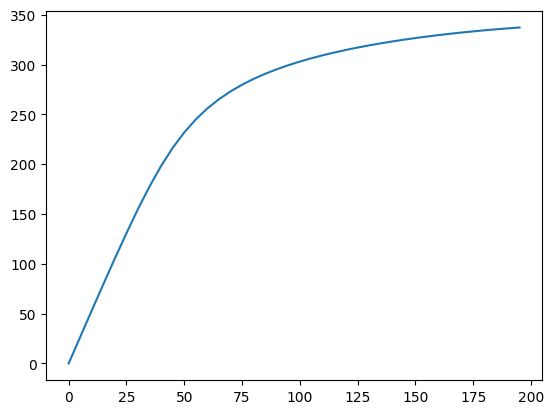

In [89]:
ref_tf = ref_traj.t[-1]
ref_tspan_rev = ref_traj.t[::-1] # Reverse the time span
Xf = np.copy(ref_traj.X[-1,:])

def V_event(t,X,p,_):
    return X[3] - 5500

V_event.direction = 1
V_event.terminal = True

X_and_lam0 = np.concatenate((Xf, [-1/np.tan(Xf[3]), 0, 0, 0]))
output = solve_ivp(lambda t,X,p,u: -traj_eom_with_costates(t,X,p,u), 
                   [0, ref_tf],
                   X_and_lam0, 
                   t_eval=ref_traj.t,
                   rtol=1e-8,
                   events=V_event,
                   args=(parameters, reference_bank_angle))
lam = output.y.T[:,4:][::-1]
X_and_lam = output.y.T[::-1]
# X_and_lam = np.column_stack((ref_traj.X[:,0], lam))

np.set_printoptions(suppress=True)
plt.plot(ref_traj.t, X_and_lam[:,1]/1e3)

# plt.plot(X_and_lam[:,2]/1e3, X_and_lam[:,0]/1e3, label='reverse')
# plt.plot(ref_traj.X[:,2]/1e3, ref_traj.X[:,0]/1e3, label='forward')
i,j = 0, 100
# plt.plot(ref_traj.t[i:j], X_and_lam[i:j,2]/1e3, label='reverse')
# plt.plot(ref_traj.t[i:j], ref_traj.X[i:j,2]/1e3, label='forward')
# plt.plot(X_and_lam[i:j,0]/1e3, X_and_lam[i:j,2]/1e3, label='reverse')
# plt.plot(ref_traj.X[i:j,0]/1e3, ref_traj.X[i:j,2]/1e3, label='forward')

plt.show()

In [92]:
class ApolloReferenceData:
    def __init__(self, X_and_lam: np.array, u: np.array, tspan: np.array, params: dict):
        """
        X_and_lam: [h, s, v, gam, lamH, lamV, lamGAM, lamU] - 8 x n matrix
        tspan: 1 x n vector
        """
        self.X_and_lam = X_and_lam
        self.tspan = tspan
        self.params = params
        self.u = u

        assert len(X_and_lam.shape) == 2 and X_and_lam.shape[0] > 1, "Need at least two rows of data"
        self.num_rows = X_and_lam.shape[0]
        
        self.delta_v = abs(X_and_lam[1,2] - X_and_lam[0,2])
        assert self.delta_v > 0, "Reference trajectory has repeated velocites in different rows"
        
        self.start_v = X_and_lam[0,2]

        F1, F2, F3, D_m, hdot_ref = self._compute_gains_and_ref()
        F3[-1] = F3[-2]   # Account for F3=0 at t=tf
        # Stack the columns as follows:
        # [t, h, s, v, gam, F1, F2, F3, D/m]
        self.data = np.column_stack((tspan, X_and_lam[:,:4], F1, F2, F3, D_m, hdot_ref))

    def _compute_gains_and_ref(self):
        h = self.X_and_lam[:,0]
        v = self.X_and_lam[:,2]
        gam = self.X_and_lam[:,3]

        lamH = self.X_and_lam[:,4]
        lamGAM = self.X_and_lam[:,6]
        lamU = self.X_and_lam[:,7]
        
        rho0 = self.params['rho0']
        H = self.params['H']
        beta = self.params['beta']   # m/(Cd * Aref)

        v2 = v*v
        rho = rho0 * exp(-h/H) 
        D_m = rho * v2 / (2 * beta)  # Drag Acceleration (D/m)
        hdot = v * sin(gam)
        
        F1 = H * lamH/D_m
        F2 = lamGAM/(v * np.cos(gam))
        F3 = lamU
        return F1, F2, F3, D_m, hdot

    def get_row_by_velocity(self, v: float):
        """
        Returns data row closest to given velocity
        """
        all_v = self.data[:,3]
        dist_to_v = np.abs(all_v - v)
        index = min(dist_to_v) == dist_to_v
        return self.data[index,:][0]
    
    def save(self, filename: str):
        """Saves the reference trajectory data to a file"""
        np.savez(filename, X_and_lam=self.X_and_lam, u=self.u, tspan=self.tspan, params=self.params)

    @staticmethod
    def load(filename: str):
        """Initializes a new ApolloReferenceData from a saved data file"""
        npzdata = np.load(filename, allow_pickle=True)
        X_and_lam = npzdata.get('X_and_lam')
        u = npzdata.get('u')
        tspan = npzdata.get('tspan')
        params = npzdata.get('params').item()
        return ApolloReferenceData(X_and_lam, u, tspan, params)

In [93]:
# Test loading and saving of data
apollo_ref = ApolloReferenceData(X_and_lam, ref_traj.u, ref_traj.t, parameters)
apollo_ref.save('apollo_data.npz')

# Load data back and check that it matches the original
ref = ApolloReferenceData.load('apollo_data.npz')
assert np.allclose(ref.data, apollo_ref.data)